<a href="https://colab.research.google.com/github/Sabujnandan/Sabujnandan/blob/main/Sabuj_userdefined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Mounting Google Drive**

In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Importing Libraries**

In [2]:
#Importing necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For handling datasets
import matplotlib.pyplot as plt  # For visualizing data
from sklearn.model_selection import StratifiedKFold  # For K-Fold cross-validation
from sklearn.preprocessing import LabelEncoder  # For encoding labels
from tensorflow.keras import layers, models  # For building neural networks
from tensorflow.keras.models import Sequential  # For sequential model
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, MaxPooling1D, Flatten  # Neural network layers
from tensorflow.keras.utils import to_categorical  # For one-hot encoding labels
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # For training optimizations

# **3. Load Dataset**

In [3]:
#Set Dataset Path
file_path = '/content/drive/MyDrive/FinalProcessedData.txt'

In [4]:
# Define column names based on your dataset
columns = ['subject_number', 'activity', 'time', 'x', 'y', 'z', 'v', 'MAx', 'MAy', 'MAz', 'MAv']

'''Raw sensor data:
'x', 'y', 'z': Accelerometer readings along 3 axes.
Derived features:
'v': Velocity magnitude (usually computed from x, y, z).
'MAx', 'MAy', 'MAz': Moving averages of x, y, z respectively (smooths noise).
'MAv': Moving average of velocity'''

# Load the dataset
data = pd.read_csv(file_path, header=None, names=columns)

# Function to safely convert to float
def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

# Convert all sensor columns to float (in case of formatting issues)
sensor_cols = ['x', 'y', 'z', 'v', 'MAx', 'MAy', 'MAz', 'MAv']
for col in sensor_cols:
    data[col] = data[col].apply(convert_to_float)

# Drop rows with any NaN values
data.dropna(inplace=True)

# Label encode activity column
label_encoder = LabelEncoder()
data['activity_encoded'] = label_encoder.fit_transform(data['activity'])

# Display cleaned dataset
data

,subject_number,activity,time,x,y,z,v,MAx,MAy,MAz,MAv,activity_encoded
0,1,DownStairs,0.000,6.482201,-1.280642,7.951946,10.338879,6.482,-1.281,7.952,10.339,0
1,1,DownStairs,0.000,6.252403,-1.280642,6.723967,9.270616,6.425,-1.281,7.645,10.072,0
2,1,DownStairs,0.009,5.831108,-1.204042,5.536680,8.130582,6.262,-1.261,7.041,9.520,0
3,1,DownStairs,0.025,5.563011,-1.357241,4.770689,7.453098,6.032,-1.281,6.246,8.798,0
4,1,DownStairs,0.042,5.524712,-1.895828,4.425993,7.328439,5.793,-1.434,5.364,8.046,0
...,...,...,...,...,...,...,...,...,...,...,...,...
115947,2,Walking,199.308,8.803493,-4.736293,-3.352644,10.543917,9.544,-4.575,-4.091,11.358,5
115948,2,Walking,199.328,8.199904,-4.906483,-2.964707,10.005073,9.050,-4.679,-3.605,10.820,5
115949,2,Walking,199.348,7.500303,-4.841877,-2.662613,9.315998,8.457,-4.766,-3.190,10.230,5
115950,2,Walking,199.369,7.088139,-4.583153,-2.598007,8.831571,7.898,-4.767,-2.894,9.674,5


# **4. Visualize Activity Distribution**

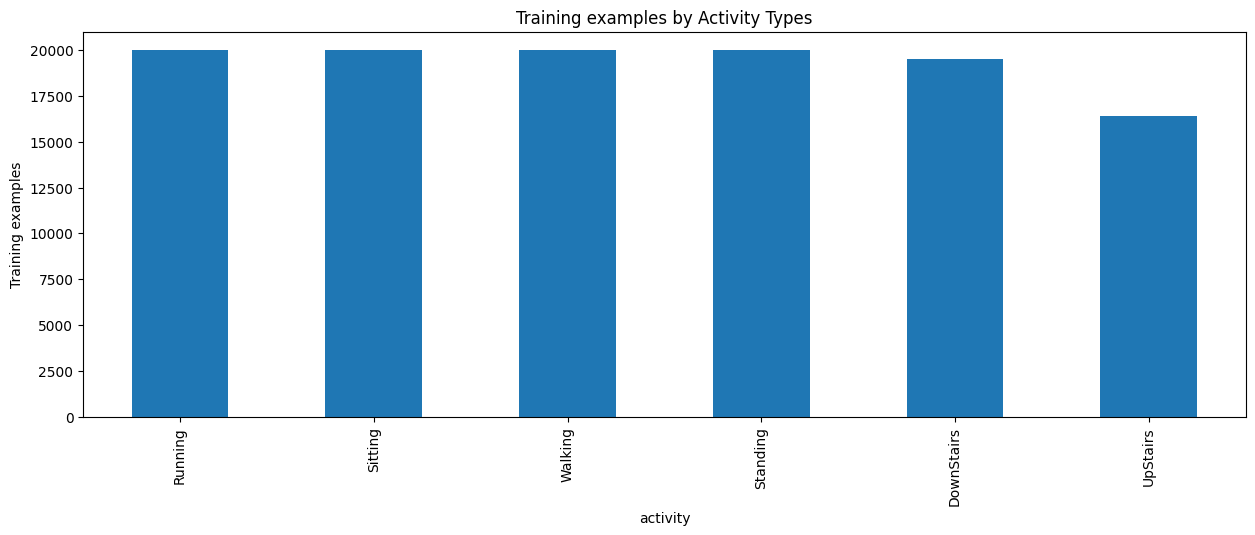

In [5]:
plt.figure(figsize=(15, 5)) #Set figure size

plt.xlabel('Activity Type') #X-axis label
plt.ylabel('Training examples') #Y-axis label

#Plot the bar chart of activity count
data['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

In [6]:
#Display the activity count
counts = data['activity'].value_counts()
print("Original Counts:\n", counts)

Original Counts:
 activity
Running       20000
Sitting       20000
Walking       20000
Standing      20000
DownStairs    19526
UpStairs      16426
Name: count, dtype: int64


In [7]:
#coversion of categorical('walking', 'jogging' etc) into numeric labels (ML model require numerical input for classification)
le = LabelEncoder() #Initialize the label encoder
data['activity'] = le.fit_transform(data['activity']) #Fit and transform activity labels

# **5. Segment Time-Series Data**

In [8]:
# Segment data into windows
def segment_data(df, window_size=200, step_size=20):
    segments = [] #To store segmented windows
    labels = [] #To store labels for each segment

    #Extract a window of data
    for i in range(0, len(df) - window_size, step_size):
        window_data = df.iloc[i: i + window_size]
        x = window_data['x'].values # X-axis values
        y = window_data['y'].values # Y-axis values
        z = window_data['z'].values # Z-axis values
        segments.append([x, y, z]) # Append window to segments
        labels.append(window_data['activity'].mode()[0]) #majority label is assigned as segment label
    return np.array(segments), np.array(labels) #Return segments and labels as arrays

# **6. Define K-Fold Cross-Validation for CNN-LSTM**

In [9]:
def kfold_validation(X, y, k=5):
    #Initialize K-Fold with stratification
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = [] #To store accuracy for each fold
    losses = [] #To store loss for each fold
    fold_numbers = [] # To track the fold numbers

    for fold, (train_index, val_index) in enumerate(skf.split(X, np.argmax(y, axis=1)), 1):
        print(f"\nTraining for Fold {fold}...")

        # Split the data into training and testing sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Define model
        input_shape = (X.shape[1], X.shape[2]) #Input shape of Conv1D model
        num_classes = y.shape[1] #Number of output classes
        #CNN-LSTM MODEL
        global model
        model = Sequential([
            Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),

            Conv1D(256, kernel_size=3, activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),

            LSTM(128, return_sequences=False),
            Dropout(0.5),

            Dense(128, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])


        #Print model summary
        if fold==1:
          model.summary()

        # Compile Model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1) #Stops training if the validation loss does not improve for 5 epochs.
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1) #Reduces the learning rate by 50% if validation loss stagnates for 3 epochs

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=20,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Evaluate the model
        loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
        print(f"Fold {fold} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

        # Store fold results
        losses.append(loss)
        accuracies.append(accuracy)
        fold_numbers.append(fold)

        # Evaluate model
        scores = model.evaluate(X_val, y_val, verbose=0)
        print(f"Fold {fold} Accuracy: {scores[1] * 100:.2f}%")

        # Plot training history for each fold
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Fold {fold} Loss')
        plt.legend()
        plt.show()

    # Plot overall results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fold_numbers, accuracies, marker='o', linestyle='-', color='b')
    plt.axhline(np.mean(accuracies), color='g', linestyle='--', label='Mean Accuracy')
    plt.title('K-Fold Cross Validation Accuracy')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.xticks(fold_numbers)
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fold_numbers, losses, marker='o', linestyle='-', color='r')
    plt.axhline(np.mean(losses), color='g', linestyle='--', label='Mean Loss')
    plt.title('K-Fold Cross Validation Loss')
    plt.xlabel('Fold Number')
    plt.ylabel('Loss')
    plt.xticks(fold_numbers)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Combined plot for Accuracy and Loss
    plt.figure(figsize=(10, 6))

    # Plot accuracy on the left y-axis
    plt.plot(fold_numbers, accuracies, marker='o', label='Accuracy')
    plt.axhline(np.mean(accuracies), linestyle='--', label='Mean Accuracy')

    # Create a second y-axis for loss
    plt.ylabel('Accuracy', color='blue')  # Left y-axis
    plt.twinx()  # Overlay a second axis

    # Plot loss on the right y-axis
    plt.plot(fold_numbers, losses, marker='o', label='Loss')
    plt.axhline(np.mean(losses), linestyle='--', label='Mean Loss')
    plt.ylabel('Loss', color='orange')  # Right y-axis

    # Titles and labels
    plt.title('K-Fold Cross Validation: Accuracy and Loss')
    plt.xlabel('Fold Number')
    plt.xticks(fold_numbers)
    plt.grid(True)

    # Legend
    plt.legend(loc='best')
    plt.show()


    # Return mean performance metrics
    return np.mean(accuracies), np.mean(losses)


In [10]:
# Loading and segmenting data
features = data[['x', 'y', 'z']].values #Extract sensor data columns
labels = data['activity'].values # Extract activity labels
# Segments has been created using a window size of 200 and 3 features (x, y, z)
window_size = 200  # Length of the time window
X_segmented, y_segmented = segment_data(data, window_size, 20)

# Reshape data for the CNN and one-hot encode labels
X_segmented = X_segmented.reshape((-1, 200, 3))  #CNN is designed to take inputs in form (sample, time_steps, features) "-1 -> reshape function calculate appropiate no of samples"
# Convert labels to one-hot encoding
y_segmented = to_categorical(y_segmented)  #e.g. ['Walking', 'Jogging', 'Sitting'] --> 'Walking' -> [1,0,0] (Categorical data into binary format)


In [12]:
# Perform K-Fold Cross Validation
average_accuracy, average_loss = kfold_validation(X_segmented, y_segmented, k=5)

# Print the results
print(f"\nFinal Average Accuracy: {average_accuracy:.4f}, Final Average Loss: {average_loss:.4f}")


Training for Fold 1...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 200, 128)       │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,782 (1.20 MB)

 Trainable params: 315,014 (1.20 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/20
 30/145 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.4700 - loss: 1.3745

KeyboardInterrupt: 


# **7. Define K-Fold Cross-Validation for CNN-LSTM**

In [41]:
def kfold_validation_lstmcnn(X, y_cat, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracies, losses, fold_numbers = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, np.argmax(y_cat, axis=1)), 1):
        print(f"\nTraining for Fold {fold}...")

        # Split into training and validation
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_cat[train_idx], y_cat[val_idx]

        input_shape = (X.shape[1], X.shape[2])  # (timesteps, features)
        num_classes = y_cat.shape[1]

        #  LSTM-CNN Model
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=input_shape),  # LSTM first
            Conv1D(64, kernel_size=3, activation='relu'),              # Then CNN
            MaxPooling1D(pool_size=2),
            Flatten(),  # Added Flatten layer here
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        if fold == 1:
            model.summary()

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
        ]

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=20,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        # Evaluate the model
        loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
        print(f"Fold {fold} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

        accuracies.append(accuracy)
        losses.append(loss)
        fold_numbers.append(fold)

        # Plot training/validation metrics
        for metric in ['accuracy', 'loss']:
            plt.figure(figsize=(10, 4))
            plt.plot(history.history[metric], label=f'Training {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'Fold {fold} {metric.title()}')
            plt.legend()
            plt.show()

    # 📈 Plot K-Fold Summary
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fold_numbers, accuracies, marker='o', linestyle='-', color='b')
    plt.axhline(np.mean(accuracies), color='g', linestyle='--', label='Mean Accuracy')
    plt.title('K-Fold Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(fold_numbers, losses, marker='o', linestyle='-', color='r')
    plt.axhline(np.mean(losses), color='g', linestyle='--', label='Mean Loss')
    plt.title('K-Fold Loss')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return np.mean(accuracies), np.mean(losses)



Training for Fold 1...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 200, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 198, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 99, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6336)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6336)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       811,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841,670 (3.21 MB)

 Trainable params: 841,670 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.7101 - loss: 0.8040 - val_accuracy: 0.8152 - val_loss: 0.4863 - learning_rate: 0.0010
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.8437 - loss: 0.4027 - val_accuracy: 0.8800 - val_loss: 0.3382 - learning_rate: 0.0010
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.8875 - loss: 0.2846 - val_accuracy: 0.8851 - val_loss: 0.2858 - learning_rate: 0.0010
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.8933 - loss: 0.2564 - val_accuracy: 0.9024 - val_loss: 0.2645 - learning_rate: 0.0010
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.9217 - loss: 0.1933 - val_accuracy: 0.8912 - val_loss: 0.2605 - learning_rate: 0.0010
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9188 - loss: 0.1885 - val_accuracy: 0.9102 - val_loss: 0.2511 - learning_rate: 0.0010
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.9

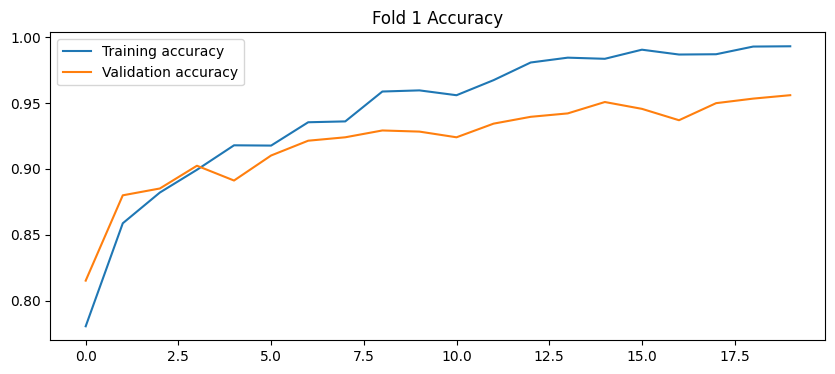

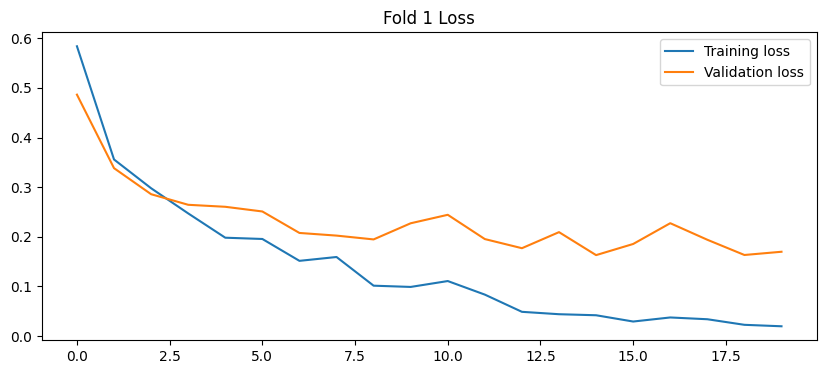


Training for Fold 2...
Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.6882 - loss: 0.8182 - val_accuracy: 0.8377 - val_loss: 0.3887 - learning_rate: 0.0010
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.8578 - loss: 0.3679 - val_accuracy: 0.8411 - val_loss: 0.3506 - learning_rate: 0.0010
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.8792 - loss: 0.2904 - val_accuracy: 0.8998 - val_loss: 0.2664 - learning_rate: 0.0010
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.8893 - loss: 0.2706 - val_accuracy: 0.9214 - val_loss: 0.2187 - learning_rate: 0.0010
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.9201 - loss: 0.1879 - val_accuracy: 0.9102 - val_loss: 0.2370 - learning_rate: 0.0010
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9226 - loss: 0.1793 - val_accuracy: 0.9188 - val_loss: 0.2331 - learning_rate: 0.0010
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 12

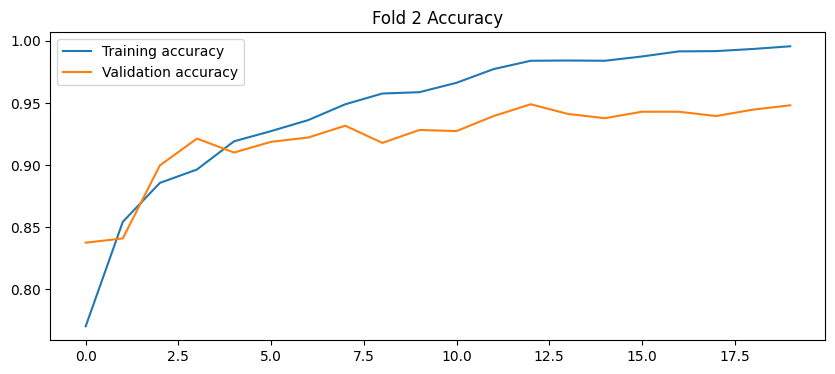

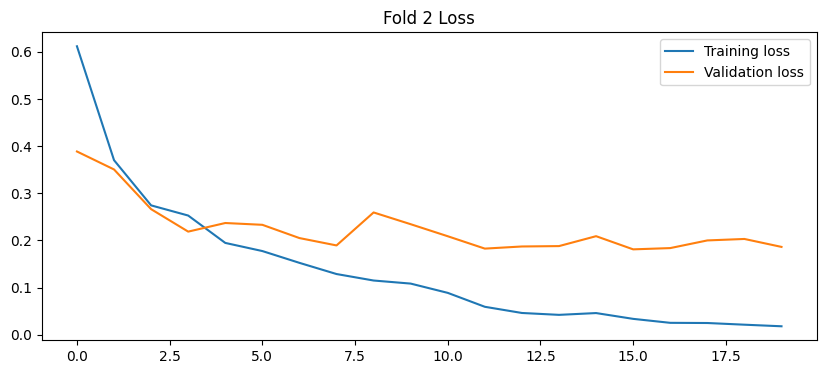


Training for Fold 3...
Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.6733 - loss: 0.8678 - val_accuracy: 0.8532 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8426 - loss: 0.3880 - val_accuracy: 0.8782 - val_loss: 0.3190 - learning_rate: 0.0010
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.8821 - loss: 0.2967 - val_accuracy: 0.8929 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.8900 - loss: 0.2628 - val_accuracy: 0.8800 - val_loss: 0.2899 - learning_rate: 0.0010
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9252 - loss: 0.1868 - val_accuracy: 0.9197 - val_loss: 0.2228 - learning_rate: 0.0010
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.9376 - loss: 0.1515 - val_accuracy: 0.8990 - val_loss: 0.2416 - learning_rate: 0.0010
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 12

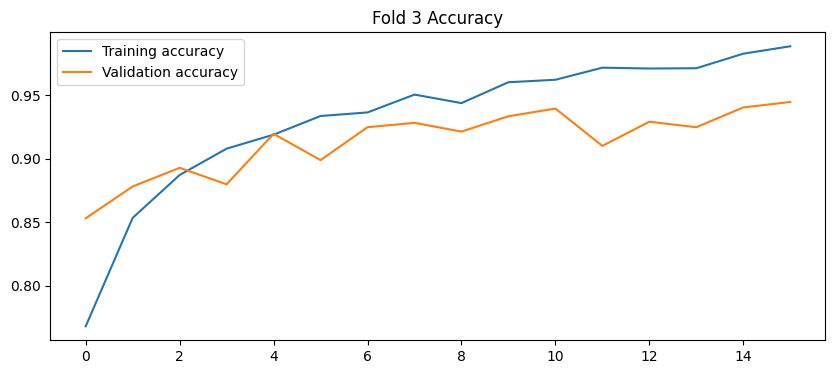

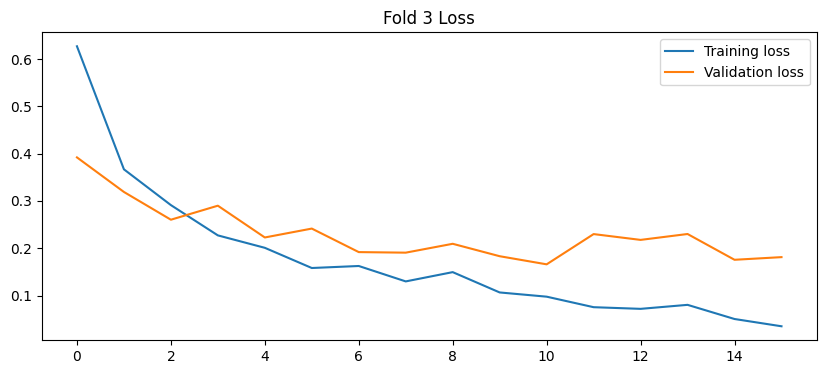


Training for Fold 4...
Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.6999 - loss: 0.8116 - val_accuracy: 0.8349 - val_loss: 0.4659 - learning_rate: 0.0010
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8568 - loss: 0.3686 - val_accuracy: 0.8453 - val_loss: 0.3892 - learning_rate: 0.0010
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.8786 - loss: 0.3153 - val_accuracy: 0.8755 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.9043 - loss: 0.2318 - val_accuracy: 0.8712 - val_loss: 0.3074 - learning_rate: 0.0010
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.9217 - loss: 0.1901 - val_accuracy: 0.8980 - val_loss: 0.2799 - learning_rate: 0.0010
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9285 - loss: 0.1827 - val_accuracy: 0.8911 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 18s 12

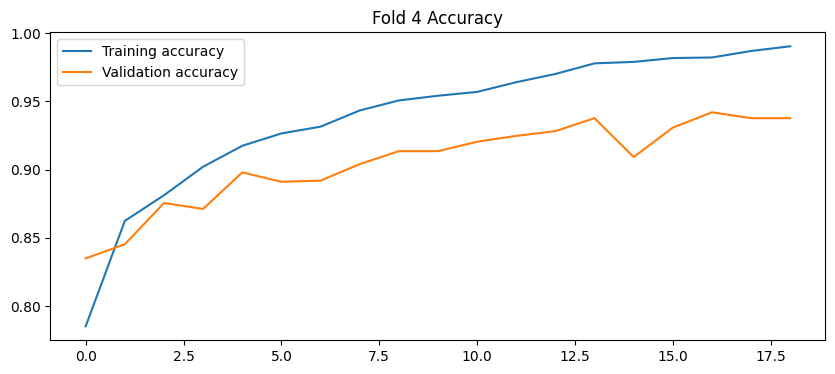

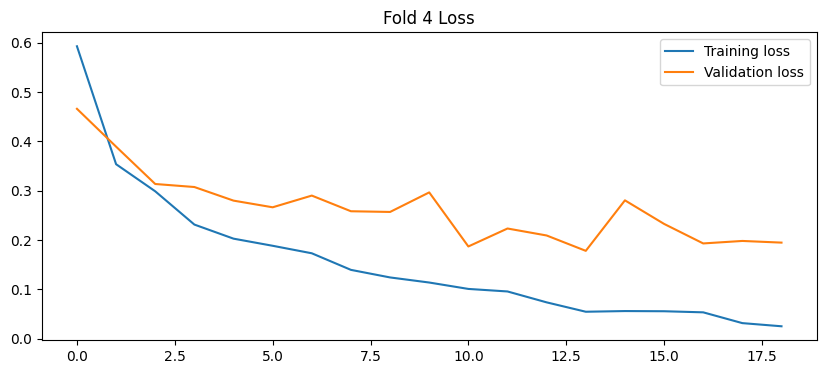


Training for Fold 5...
Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.6700 - loss: 0.8911 - val_accuracy: 0.8245 - val_loss: 0.4398 - learning_rate: 0.0010
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.8451 - loss: 0.3991 - val_accuracy: 0.8712 - val_loss: 0.3204 - learning_rate: 0.0010
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.8815 - loss: 0.3011 - val_accuracy: 0.8937 - val_loss: 0.2464 - learning_rate: 0.0010
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8900 - loss: 0.2662 - val_accuracy: 0.8902 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9142 - loss: 0.2262 - val_accuracy: 0.9015 - val_loss: 0.2375 - learning_rate: 0.0010
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.9310 - loss: 0.1774 - val_accuracy: 0.9084 - val_loss: 0.2226 - learning_rate: 0.0010
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 18s 12

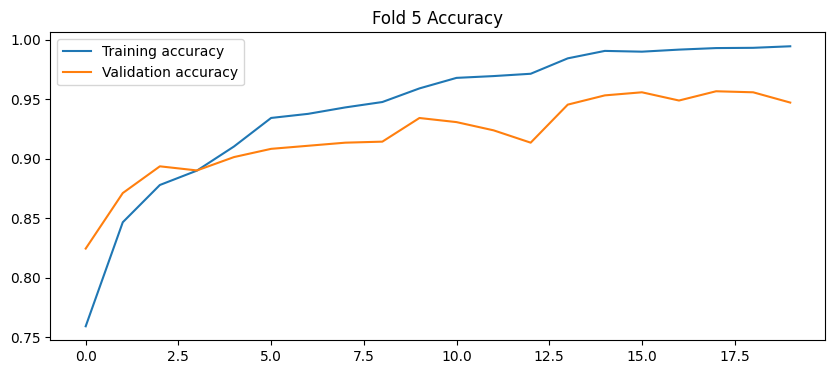

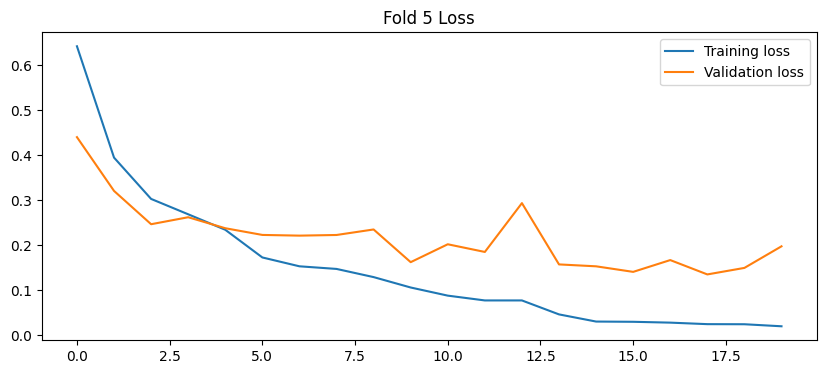

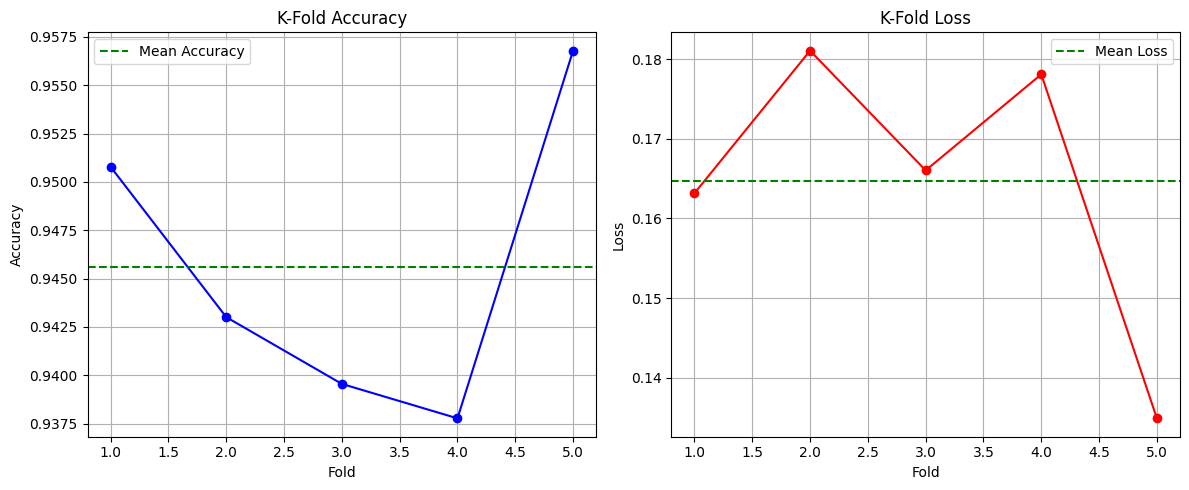


Final Average Accuracy: 0.9456, Final Average Loss: 0.1647


In [19]:
average_accuracy, average_loss = kfold_validation_lstmcnn(X_segmented, y_segmented, k=5)
print(f"\nFinal Average Accuracy: {average_accuracy:.4f}, Final Average Loss: {average_loss:.4f}")


# **Displaying the Final Plot**

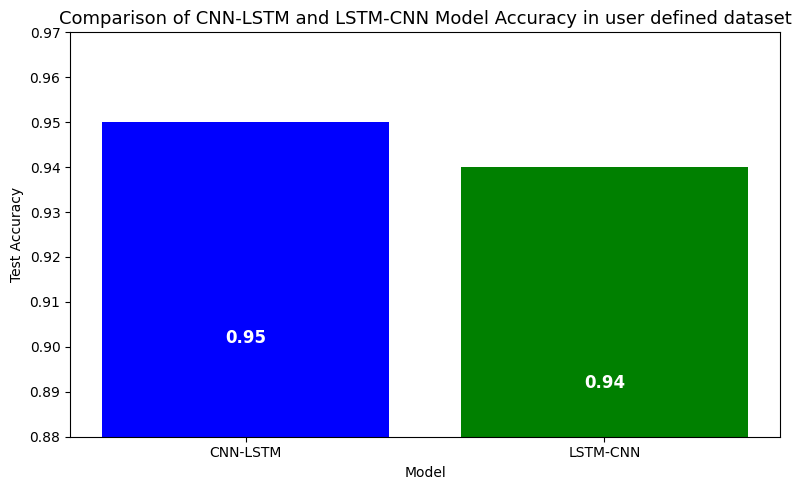

In [47]:
import matplotlib.pyplot as plt

def plot_model_comparison(cnn_lstm_acc=0.95, lstm_cnn_acc=0.94):
    models = ['CNN-LSTM', 'LSTM-CNN']
    accuracies = [cnn_lstm_acc, lstm_cnn_acc]
    colors = ['blue', 'green']

    plt.figure(figsize=(8, 5))
    bars = plt.bar(models, accuracies, color=colors)

    # Annotate accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height - 0.05,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='white')

    plt.ylim(0.88, 0.97)

    plt.title('Comparison of CNN-LSTM and LSTM-CNN Model Accuracy in user defined dataset', fontsize=13)
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy')
    plt.tight_layout()
    plt.show()
plot_model_comparison()
